In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import re
import contractions
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge as R
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score as acu

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Bidirectional, Dense
from tensorflow.keras import Model
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.math import rint, reduce_sum, divide, exp, subtract, greater_equal
from tensorflow.math import round as rounding
from tensorflow.random import set_seed
from tensorflow import cast, constant
from tensorflow.nn import softmax

from plot_keras_history import plot_history

from transformers import BertTokenizer, TFBertForSequenceClassification

import gensim
import gensim.downloader as api

seed = 5
np.random.seed(seed)
set_seed(seed)

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<p style="font-size : 16px">Reading the text data and separating the target (y):</p>

In [2]:
train, test = pd.read_csv("kaggle/input/nlp-getting-started/train.csv"), pd.read_csv("kaggle/input/nlp-getting-started/test.csv")
y=train.target.values

#### Data Preparation

Emojis are not relevant for text analysis, so they should be removed.

In [3]:
emojis = ["\U0001F600", "\U0001F64F", "\U0001F300", "\U0001F5FF", "\U0001F680", "\U0001F6FF", "\U0001F1E0", "\U0001F1FF", "\U00002702", "\U000027B0", "\U000024C2", "\U0001F251"]
emojis

['😀', '🙏', '🌀', '🗿', '🚀', '\U0001f6ff', '\U0001f1e0', '🇿', '✂', '➰', 'Ⓜ', '🉑']

Stopwords are words with no specific meaning like "a", "the", or "by". It is important to remove them for text mining, but not for NLP. For neural networks that process sentences sequentially, such as 1D-CNN or RNN, stopwords are an important indicator of context.

In [4]:
nltk.download('stopwords')
stopWords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ramtin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


The regex tokenizer used here separates the words of a contiguous string into a list consisting of words only. "\w+" means that all word characters contiguous are turned into a list element.

In [5]:
token = nltk.tokenize.RegexpTokenizer(r"\w+")

Word stemming uses algorithms to find the root form of words by removing common endings. While this is computationally efficient, it can produce awkward or incorrect results - for instance, reducing "peoples" or "people" to "peopl". Sometimes stemming algorithms can be too aggressive, cutting off too much of the word in what's known as overstemming.

Lemmatization takes a different approach. Instead of using rules to strip words down, it refers to a dictionary to find the proper base form (lemma) of each word. The tradeoff is that lemmatization can only process words that exist in its dictionary. For our purpose of creating word clouds, we'll use lemmatization since we want to display actual, readable words rather than truncated stems.

In [6]:
lemmatizer = nltk.stem.WordNetLemmatizer()

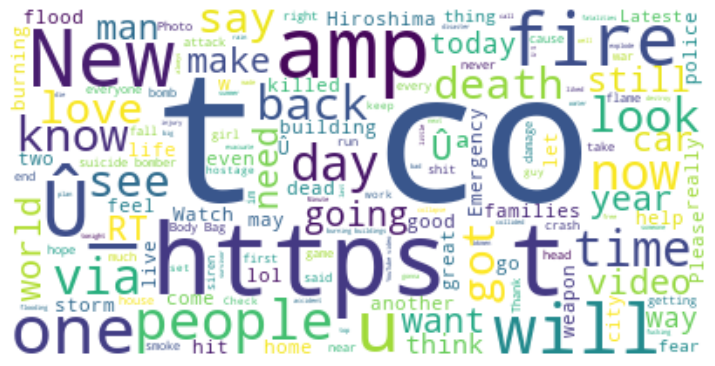

In [7]:
wc = WordCloud(background_color='white').generate(" ".join(train.text))
plt.figure(figsize=(10, 20), dpi=90)
plt.axis('off')
plt.imshow(wc, interpolation="bilinear")
plt.show()

We're creating a flexible text cleaning function that can be customized for different text analysis purposes (text mining or NLP). The function applies several cleaning steps in a specific sequence:

- Converts all text to lowercase to ensure consistent word comparison, especially for words at the start of sentences
- Removes URLs (containing "http" or "@")
- Expands English contractions to their full form (e.g., "don't" to "do not")
- Eliminates extra whitespace before and after words using .strip()
- Filters out numbers
- Removes common special characters (like "ûª")
- Deletes single letters

The sequence of these cleaning steps is crucial. For example, if you remove single letters before expanding contractions, you might end up with leftover single letters from the expansion. Even with careful ordering, isolated letters may still appear after all cleaning steps.
The function is designed to be flexible - you can skip more aggressive cleaning steps when needed. It also separates the dataset into two categories: fake news and real news.

In [8]:
def cleaner(DF, labeled=True, stopWrds=True, Lemmatize=True, dropDigits=True, dropSinLet=True, c="text"):
    fake = []
    real = []
    data = []
    col = np.where(DF.columns == c)[0][0]
    
    for i, row in enumerate(DF.iterrows()):

        sentence = row[1][col]
        sentence = sentence.lower().split(" ")
        sentence = [word for word in sentence if word not in emojis]
        sentence = [word for word in sentence if 
                  "http" not in word and 
                  "https" not in word and 
                  "@" not in word]
        sentence=[contractions.fix(word) for word in sentence]
        sentence=" ".join(sentence).lower()
        sentence=token.tokenize(sentence)
        if stopWrds == True:
            sentence =[word for word in sentence if word not in stopWords]
        if Lemmatize == True:
            sentence= [lemmatizer.lemmatize(word) for word in sentence]
        sentence = [word.strip() for word in sentence]
        if dropDigits == True:
            sentence = [word for word in sentence if not re.match(r"\S*\d+\S*", word)]
        sentence = [word for word in sentence if 
                  word != "rt" and 
                  word != "û_" and 
                  word != "amp" and 
                  word != "ûª" and
                  word != "ûªs" and
                  word != "ûò" and
                  word != "åè" and
                  word != "ìñ1"] 
        sentence=[re.sub(r"(.)\1{2,}\B", r"\1\1", word) for word in sentence]
        sentence=[re.sub(r"(.)\1{2,}\b", r"\1\1", word) for word in sentence]
        if dropSinLet == True:
            sentence=[word for word in sentence if len(word) > 1]
        sentence=[word for word in sentence if len(word) < 30]
        
        if labeled == True:
            if row[1][4] == 1:
                fake.extend(sentence)
            else:
                real.extend(sentence)

        data.append(" ".join(sentence))
        
    return data, fake, real

Here we apply the function to the training dataset and to the test dataset.

In [9]:
nltk.download('wordnet')
tr, F, T = cleaner(train)
te, e, e = cleaner(test, labeled=False)

[nltk_data] Downloading package wordnet to /Users/ramtin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/var/folders/qr/fcd80nbj48qb5j4bp_vdd6lm0000gn/T/ipykernel_3035/1652137272.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence = row[1][col]
/var/folders/qr/fcd80nbj48qb5j4bp_vdd6lm0000gn/T/ipykernel_3035/1652137272.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][4] == 1:


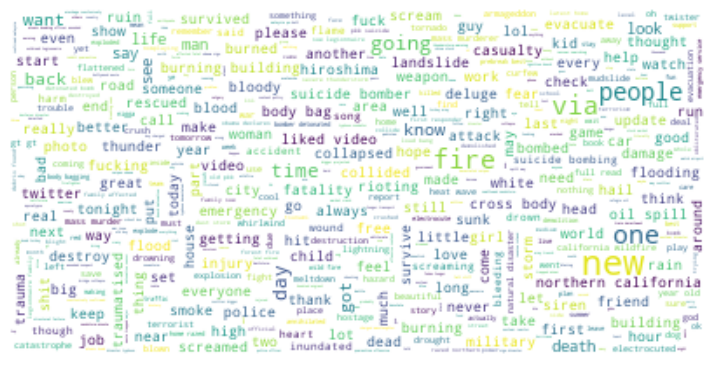

In [10]:
wc=WordCloud(
    max_words = 3000, 
    relative_scaling = 1,
    max_font_size = 20,
    min_font_size = 2,
    background_color = "white",
).generate(" ".join(tr))
plt.figure(figsize=(10, 20), dpi=90)
plt.axis('off')
plt.imshow(wc, interpolation = "bilinear")
plt.show()

<p style="font-size : 16px">The following word cloud is divided into fake news and real news. The larger the word, the more often it appears.</p>

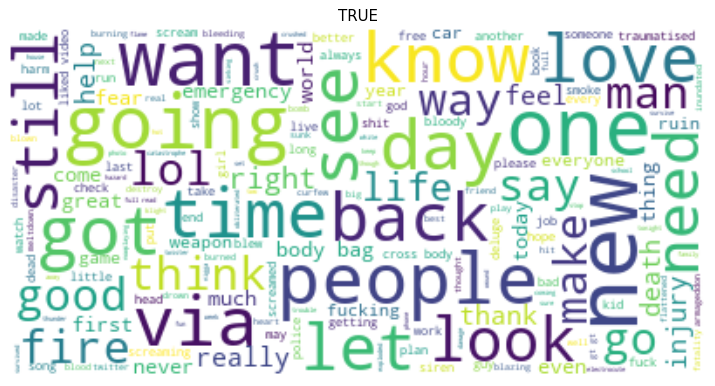

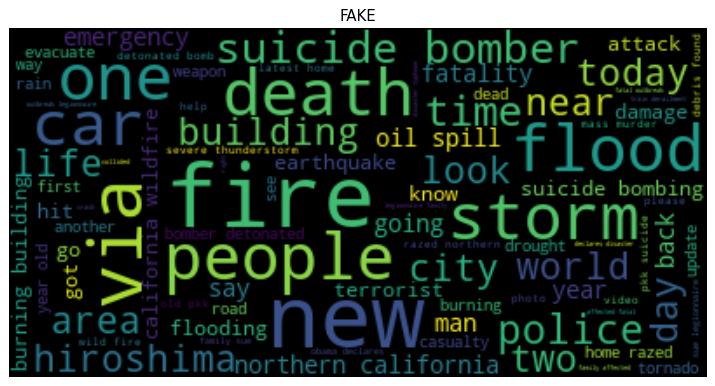

In [11]:
for C, W in {"white": T, "black": F}.items():
    wc=WordCloud(
        background_color=C, 
        max_font_size=50,
        max_words=2000,
        width=400, height=200
    ).generate(" ".join(W))
    plt.figure(figsize=(10,20), dpi=90)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title('TRUE' if C == "white" else "FAKE")
    plt.show()

Analysis reveals a distinct pattern: real news articles generally contain more positive vocabulary, while fake news tends to use more negative words. 

However, some common words like "new" and "time" appear frequently in both categories. This overlap highlights why simple word-based classification would be unreliable - without considering the broader context and how words are used together, we can't accurately distinguish between real and fake news articles based on vocabulary alone.



In [12]:
np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2])
te_val, _, _ = cleaner(train.loc[r <= 0.2], labeled=False)

/var/folders/qr/fcd80nbj48qb5j4bp_vdd6lm0000gn/T/ipykernel_3035/1652137272.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence = row[1][col]
/var/folders/qr/fcd80nbj48qb5j4bp_vdd6lm0000gn/T/ipykernel_3035/1652137272.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][4] == 1:


#### Text Mining with Frequency Plot

Let's analyze which words appear exclusively in either the test or training datasets. 
Words that are unique to the training set likely won't play a crucial role in classification, since their importance couldn't be validated in the test set. 
More concerning are words that appear only in the test set - since these words weren't present during training, the model won't have learned how to properly interpret them for classification purposes.

In [13]:
just_real = [w for w in T if w not in F]
just_fake = [w for w in F if w not in T]

In [14]:
Just_Real = nltk.probability.FreqDist()
Just_Fake = nltk.probability.FreqDist()

for w in just_real:
    Just_Real[w] += 1

for w in just_fake:
    Just_Fake[w] += 1

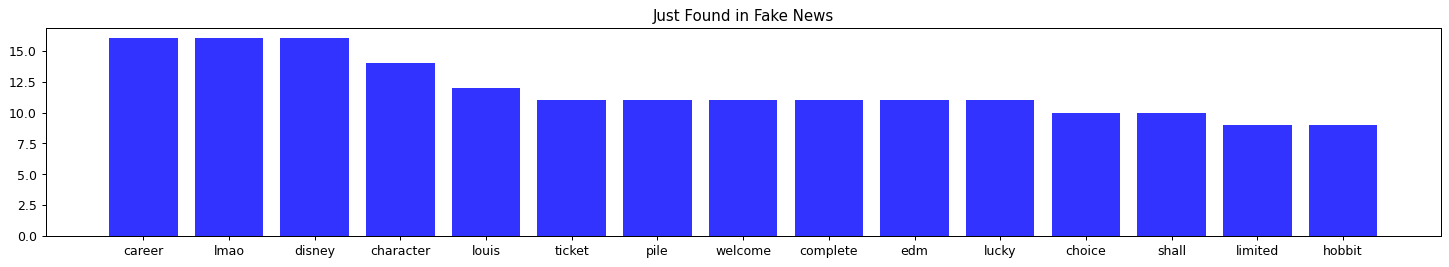

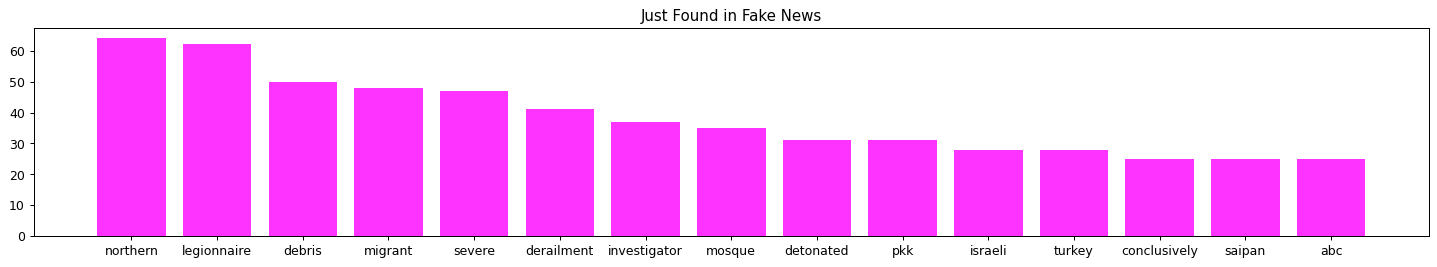

In [15]:
for C, W in {"blue": Just_Real, "magenta": Just_Fake}.items():
    Frequency = pd.DataFrame({"Words": list(W.keys()),"Frequency": list(W.values())})
    Frequency = Frequency.sort_values("Frequency", ascending=False).iloc[:15]
    plt.figure(figsize=(20, 3), dpi=90)
    if C == "green":
        plt.title("Just Found in Real News")
    else:
        plt.title("Just Found in Fake News")
    plt.bar(Frequency.Words, Frequency.Frequency, color=C, alpha=0.8)

#### Prepare Text for ML

Since we're dealing with binary text classification (categorizing text into one of two groups), we could potentially use any standard classification algorithm, including:

- Logistic/Probabilistic Regression
- K-nearest neighbors
- Decision trees
- Support Vector Machines
- Neural Networks

As we're focusing on Neural networks in this course, I'm going to use a Neural Networks model using LSTM.


Long Short Term Memory (LSTM) networks enhance traditional neural networks by incorporating loops that act as memory, along with a special "cell state" that functions as long-term memory by selectively forgetting old information and learning new information. For complex language processing where meaning depends on both forward and backward context, a bidirectional LSTM is used to analyze text in both directions.

Rather than using one-hot encoding, which can create high variance due to its sparse representation, we opt for word embeddings. Word embeddings work by feeding a one-hot matrix through hidden layers of a neural network, where each hidden layer creates learned features that represent the words. This embedding process essentially acts as a preliminary neural network that converts categorical data into dense numerical features.

The process has two key parameters: input_dim (the total number of unique categories to encode) and output_dim (how many features you want in your final representation). While a smaller output_dim means some information is lost, it helps reduce complexity and variance in the model's predictions.

In [16]:
def BiDirLSTM(vocSize, inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    inp = Input(shape = (inpShape), name = "input")
    emb = Embedding(
        input_dim = vocSize,
        output_dim = 4
    )(inp)
    drop = Dropout(0.3)(emb)
    biLstm = Bidirectional(
        LSTM(
            units=16,
            activation='tanh',
            return_sequences = True,
            stateful=False,
            recurrent_dropout = 0.4,
            dropout=0.4
        )
    )(drop)
    biLstm = Bidirectional(
        LSTM(
            units = 8,
            activation ='tanh',
            return_sequences = False,
            stateful = False,
            recurrent_dropout = 0.3,
            dropout = 0.3
        )
    )(biLstm)

    out = Dense(units = 1, activation = "sigmoid")(biLstm)

    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [17]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr_val)
tr_val = tokenizer.texts_to_sequences(tr_val)
te_val = tokenizer.texts_to_sequences(te_val)

vocabulary_size_val = len(tokenizer.index_word)+1
length_val=max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])


In [18]:
def BiDirLSTM(vocSize, inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    inp = Input(shape = (inpShape,), name = "input")
    emb = Embedding(
        input_dim = vocSize,
        output_dim = 4
    )(inp)
    drop = Dropout(0.3)(emb)
    biLstm = Bidirectional(
        LSTM(
            units=16,
            activation='tanh',
            return_sequences = True,
            stateful=False,
            recurrent_dropout = 0.4,
            dropout=0.4
        )
    )(drop)
    biLstm = Bidirectional(
        LSTM(
            units = 8,
            activation ='tanh',
            return_sequences = False,
            stateful = False,
            recurrent_dropout = 0.3,
            dropout = 0.3
        )
    )(biLstm)

    out = Dense(units = 1, activation = "sigmoid")(biLstm)

    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [19]:
model = BiDirLSTM(vocabulary_size_val, length_val)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 21, 4)          │        44,116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 21, 32)         │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 16)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,445 (193.14 KB)

 Trainable params: 49,445 (193.14 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
optimizer = Adamax(
    decay=0.0005, 
    clipvalue=10
)

/opt/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [21]:
loss = BinaryCrossentropy(label_smoothing=0.01)

In [22]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy", "AUC", "Precision", "Recall"]
)

In [23]:
# convert tr_val and te_val to numpy arrays
tr_val = pad_sequences(tr_val, maxlen=length_val, padding='post')
te_val = pad_sequences(te_val, maxlen=length_val, padding='post')


history = model.fit(
    x = tr_val, 
    y = y_tr_val,
    validation_data = (te_val, y_te_val),
    epochs = 50,
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - AUC: 0.4928 - Precision: 0.4627 - Recall: 0.0798 - accuracy: 0.5742 - loss: 0.6877 - val_AUC: 0.6407 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5710 - val_loss: 0.6819
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - AUC: 0.5303 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5792 - loss: 0.6800 - val_AUC: 0.7039 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5710 - val_loss: 0.6800
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.5644 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.5792 - loss: 0.6781 - val_AUC: 0.7465 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5710 - val_loss: 0.6764
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - AUC: 0.6278 - Precision: 0.2923 - Recall: 1.2831e-04 - accuracy: 0.5793 - loss: 0.6718 - val_AUC: 0.7725 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.5710 - va

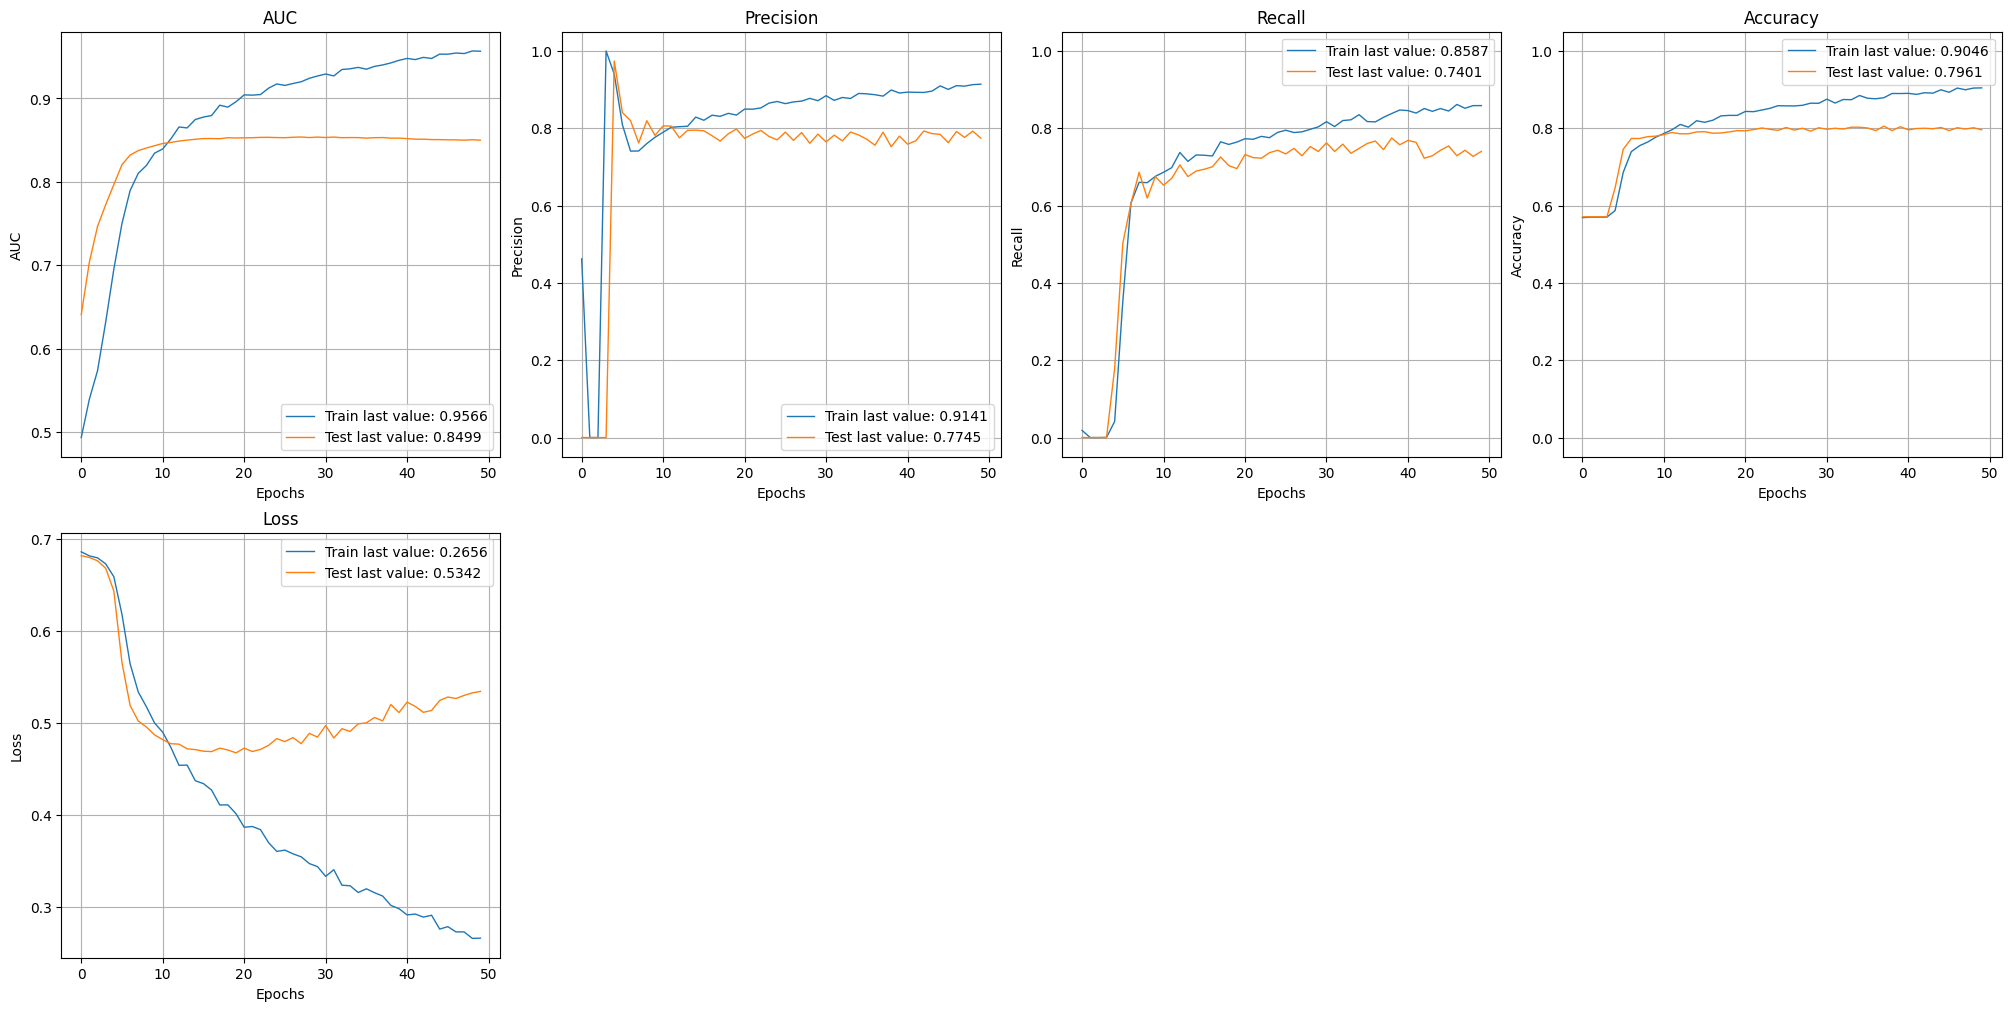

In [24]:
plot_history(history)
plt.show()

In [27]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, _, _ = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

/var/folders/qr/fcd80nbj48qb5j4bp_vdd6lm0000gn/T/ipykernel_3035/1652137272.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentence = row[1][col]
/var/folders/qr/fcd80nbj48qb5j4bp_vdd6lm0000gn/T/ipykernel_3035/1652137272.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if row[1][4] == 1:


In [44]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr)
tr = tokenizer.texts_to_sequences(tr)
te = tokenizer.texts_to_sequences(te)

vocabulary_size = len(tokenizer.index_word)+1

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [45]:
length=max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [30]:
tr = pad_sequences(tr, padding='post', maxlen=length)
te = pad_sequences(te, padding='post', maxlen=length)

In [31]:
model = BiDirLSTM(vocabulary_size, length)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 32, 4)          │        55,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 32, 32)         │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 16)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,869 (237.77 KB)

 Trainable params: 60,869 (237.77 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model.compile(
    loss = loss, 
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    x=tr, 
    y=y,
    epochs = 50,
    batch_size = 96, 
    shuffle = True,
    verbose=0
)

In [36]:
Predictions = model.predict(
    x=te
)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


<p style="font-size : 16px">Let's look at the predicted probabilities.<p/>

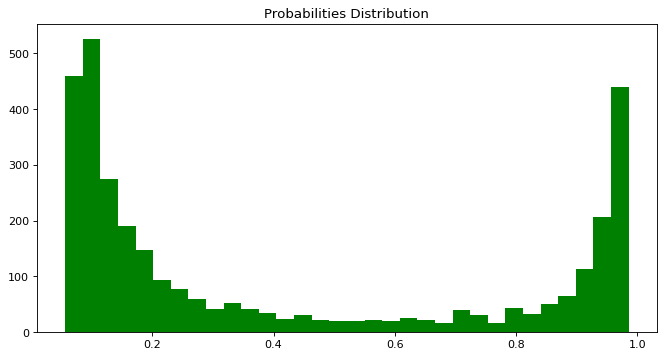

In [37]:
baseline = Predictions
plt.figure(figsize = (10,5), dpi = 80)
plt.hist(
    baseline, 
    bins = 32, 
    color = 'g',
    label = 'baseline'
)

plt.title('Probabilities Distribution')
plt.show()

In [39]:
subm = pd.read_csv("kaggle/input/nlp-getting-started/sample_submission.csv")

In [40]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
5,12,1
6,21,0


In [41]:
subm.to_csv("Submission_Basic.csv", index=False)

<font size="+3" color="grey"><b>3. Word2Vec with GenSim </b></font><br><a id="3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">As mentioned above, tokenization must always be "trained" on the training data set. This means that the test data set contains words that cannot be assigned by the algorithm. If one continues the consideration, then one finds out that a similar problem is also present in the training data set itself. Since words can also be replaced by synonyms, but synonyms do not always say exactly the same thing, it would make sense to describe the individual words by their similarity to each other instead of a simple tokenization that just assigns a value to each word. This would have the advantage that similar words would also be interpreted similarly. This is the idea behind Unsupervised Learning approaches. Here a kind of autoencoder is trained, which takes up the individual words by embeddings, reduces these in their dimensionality e.g. to 200 and then restores again. The resulting embeddings yield 200 dimensions for each word, which represent the context of the word in the respective introduced text. Now only each word in the text must be replaced by these e.g. 200 dimensions. You can imagine that this will be a big computational effort. But it is worth it. Studies show that the performance of the algorithms can be increased significantly.</p>

<img height="800" width="800" src="https://cdn-images-1.medium.com/max/1600/1*SFuHVAWXWB914rSGAZYLzA.png">
<p style="font-size : 12px"><em>Image from: <a href="https://towardsdatascience.com/word2vec-made-easy-139a31a4b8ae">here</a></em></p>

<p style="font-size : 16px">There are two different architectures. Continuous bag-of-words (CBOW) or continuous skip-gram. In the continuous bag-of-words architecture, the model predicts the current word from a window of surrounding context words wherehe the order of context words does not influence prediction. In the continuous skip-gram architecture, the model uses the current word to predict the surrounding window of words. The skip-gram architecture gives nearby context words a higher weight than more distant context words. The following is an example of the sentence "the quick brown fox jumps over the lazy dog" with a window size of two.</p>

<img height="700" width="700" src="https://cdn-images-1.medium.com/max/1600/1*yiH5sZI-IBxDSQMKhvbcHw.png">
<p style="font-size : 12px"><em>Image from: <a href="https://medium.com/ml2vec/using-word2vec-to-analyze-reddit-comments-28945d8cee57">here</a></em></p>

<p style="font-size : 16px">But there is also a less computationally intensive variant that increases performance. Word2Vec also makes it possible to find synonyms that match the context of the text. These can be applied to the test and validation data set and then lead to fewer unknown words being found in it. Here we will use both variants</p>

In [ ]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, o, o = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

<font size="+1" color="grey"><b>3.1 Word2Vec</b></font><br><a id="3.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">  </p>

In [ ]:
emb = [s.split(" ") for s in tr]
emb.extend([s.split(" ") for s in te])

<p style="font-size : 16px">A good tuning of the parameters is important. This can be easily checked by synonyms. If the synonyms make sense in context, then the tuning probably worked.</p>

* We use all words (train and test) for the training
* min_count is the minimum number of words for which the methods should be applied
* window is the windowsize.
* sg = 1 means use skip gram sg =  means use CBOW.

<p style="font-size : 16px">A good tuning of the parameters is important. This can be easily checked by synonyms. If the synonyms make sense in context, then the tuning probably worked. Below, we check whether the most likely synonyms (this must always be considered in the context of the data set) make sense.<p>

In [ ]:
w2v =  gensim.models.Word2Vec(
    emb, 
    min_count=4,
    workers=4, 
    window =5, 
    sg = 1
)

words=["fire", "flood", "died", "accident", "closed", "help", "twitter", "air", "everything"]

for w in words:
    print(w + " is " + w2v.wv.most_similar(w, topn=1)[0][0])

<p style="font-size : 16px">At least from the feeling the synonyms fit into the context of the text. Now we replace the words that do not occur in the training data set but do occur in the test data set with the most likely synonyms.</p>

In [ ]:
def wordChanger(trainList, testList, minSimilar=0.5, numPrint=300):

    te_listList = [s.split(" ") for s in testList]

    tr_uniques=set(" ".join(trainList).split(" "))
    wc = 0
    try:
        for i, s in enumerate(te_listList):
            for j, w in enumerate(s):
                if w not in tr_uniques and w in w2v.wv.index_to_key and w2v.wv.most_similar(w, topn=1)[0][0] in tr_uniques \
                and w2v.wv.most_similar(w, topn=1)[0][1] >= minSimilar:
                    te_listList[i][j] = w2v.wv.most_similar(w, topn=1)[0][0]
                    wc += 1
                    if i < numPrint:
                        print(w + " changed in " + w2v.wv.most_similar(w, topn = 1)[0][0])

    except Error as e:
        print(w + " Err: " + e)

    print(str(wc) + " words changed")
    
    te_listList = [" ".join(s) for s in te_listList]
    
    return te_listList

In [ ]:
te_val = wordChanger(tr_val, te_val)

<font size="+1" color="grey"><b>3.2 LSTM with Context Synonyms</b></font><br><a id="3.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px"> Now we use the same model again, only with the difference that now more words should be known in the validation data set. </p>

In [ ]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr_val)
tr_val = tokenizer.texts_to_sequences(tr_val)
te_val = tokenizer.texts_to_sequences(te_val)

vocabulary_size_val = len(tokenizer.index_word)+1

In [ ]:
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

In [ ]:
tr_val = pad_sequences(tr_val, padding='post', maxlen=length_val)
te_val = pad_sequences(te_val, padding='post', maxlen=length_val)

In [ ]:
model = BiDirLSTM(vocabulary_size_val, length_val)

In [ ]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    x = tr_val, 
    y = y_tr_val,
    validation_data = (te_val, y_te_val),
    epochs = 10, 
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

In [ ]:
plot_history(history)
plt.show()

<p style="font-size : 16px">It is noticeable that even by adjusting so few words in the validation dataset, an improvement of the stability of the model occurred - which is not surprising, since more words were known in context. </p>

<font size="+1" color="grey"><b>3.3 Submission Word2Vec Context Synonyms</b></font><br><a id="3.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [ ]:
te = wordChanger(tr, te)

In [ ]:
tokenizer = Tokenizer(num_words=None)
tokenizer.fit_on_texts(tr)
tr = tokenizer.texts_to_sequences(tr)
te = tokenizer.texts_to_sequences(te)

vocabulary_size = len(tokenizer.index_word)+1

In [ ]:
length=max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [ ]:
tr = pad_sequences(tr, padding='post', maxlen=length)
te = pad_sequences(te, padding='post', maxlen=length)

In [ ]:
model = BiDirLSTM(vocabulary_size, length)

In [ ]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    x = tr, 
    y = y,
    epochs = 10, 
    batch_size = 96, 
    shuffle = True,
    verbose =0
)

In [ ]:
Predictions = model.predict(
    x=te
)

<p style="font-size : 16px">Compare the distribution of the predictions with the baseline:</p>

In [ ]:
def comHist(base, pred, lab :str):
    plt.figure(figsize=(10,5), dpi= 80)
    plt.hist(
        base, 
        bins=32, 
        alpha=1, 
        color='g',
        label='baseline', 
    )

    plt.hist(
        pred, 
        bins=32, 
        alpha=0.5, 
        color='r',
        label=lab,
        linestyle='dashed',
        edgecolor = 'w'
    )
    plt.legend(loc='upper right')
    plt.title('Probabilities Distribution')
    plt.show()

In [ ]:
comHist(baseline, Predictions, "Word2Vec Synonyms")

<p style="font-size : 16px">Large differences are mainly found in the extreme values zero and one.</p>

In [ ]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

In [ ]:
subm.to_csv("Submission_W2V.csv", index=False)

In [ ]:
colors=np.array(Image.open("../input/imagesforkernels/w2v-subm.JPG"))
width=colors.shape[1]
height=colors.shape[0]
plt.figure(figsize=(2, 3))
plt.axis('off')
plt.imshow(colors)
plt.show()

<font size="+1" color="grey"><b>3.4 Glove Embeddings with GenSim</b></font><br><a id="3.4"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [ ]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, o, o = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low = 0.0, high = 1.0, size = train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, o, o = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, o, o = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

<p style="font-size : 16px">GenSim has a downloader that can be used to load pre-trained models. There is a pretrained vector from Twitter (glove twitter 25) generated from tweets. The 25 stands for the number of dimensions </p>

In [ ]:
glove = api.load("glove-twitter-25")

for w in words:
    print(w + " is " + glove.most_similar(w, topn=1)[0][0])

<p style="font-size : 16px"> To limit the computational effort, we reduce the size of the embeddings from 100 to vecSize. To be able to display all words, it is also necessary to set the minimum size to 1.</p>

In [ ]:
vecSize = 25
w2v = gensim.models.Word2Vec(
    emb, 
    vector_size = vecSize,
    min_count = 1,
    workers = 4, 
    window = 6, 
    sg = 1
)

for w in words:
    print(w + " is " + w2v.wv.most_similar(w, topn=1)[0][0])

<p style="font-size : 16px"> Looks still pretty good. Now we use the predtraines glove vector if the word is available, else we use our own w2v. </p>

In [ ]:
def gloveEmbedder(df_tr, df_te):
    etr = []
    ete = []

    for s in df_tr:
        s = [glove[f"{w}"] if w in glove.index_to_key else w2v.wv[f"{w}"] for w in s.split()]
        s = list(np.ravel(s))
        etr.append(s)

    for s in df_te:
        s = [glove[f"{w}"] if w in glove.index_to_key else w2v.wv[f"{w}"] for w in s.split()]
        s = list(np.ravel(s))
        ete.append(s)

    l=max([max([len(i) for i in etr]), max([len(i) for i in ete])])

    print("Each sentence will have a lengt of " + str(l))
    return etr, ete, l

In [ ]:
emb_tr_val, emb_te_val, length_val = gloveEmbedder(tr_val, te_val)

<p style="font-size : 16px"> It is important to change the data type to a float datatyp.</p>

In [ ]:
emb_tr_val = pad_sequences(emb_tr_val, padding='post', maxlen=length_val, dtype='float32')
emb_te_val = pad_sequences(emb_te_val, padding='post', maxlen=length_val, dtype='float32')

<p style="font-size : 16px"> Reshaping for LSTM. Since we already have the embeddings, we will apply the LSTM without embeddings. Therefore, the shape of the dataset must be divided into (samples, timesteps, features). We have a 20 dimensional embedding. Each set will be a sample with 680 timesteps and 20 features.</p>

In [ ]:
timesteps=int(length_val/vecSize)
emb_tr_val = emb_tr_val.reshape(-1, timesteps, vecSize)
emb_te_val = emb_te_val.reshape(-1, timesteps, vecSize)
shape = emb_tr_val.shape[1:]

In [ ]:
def BiDirLSTM(inpShape, seeds = seed):
    np.random.seed(seeds)
    set_seed(seeds)
    
    inp = Input(shape = (inpShape), name = "input")
    drop = Dropout(0.4)(inp)
    biLstm = Bidirectional(
        LSTM(
            units =192,
            activation ='tanh',
            return_sequences = True,
            stateful = False,
            recurrent_dropout = 0.4,
            dropout = 0.4
        )
    )(drop)
    biLstm = Bidirectional(
        LSTM(
            units = 8,
            activation = 'tanh',
            return_sequences = False,
            stateful = False,
            recurrent_dropout = 0.4,
            dropout = 0.3
        )
    )(biLstm)

    out = Dense(units = 1, activation = "sigmoid")(biLstm)

    m = Model(inputs = inp, outputs = out)
    m.summary()
    return m

In [ ]:
model = BiDirLSTM(inpShape = shape)

In [ ]:
optimizer = Adamax(
    lr = 0.015, 
    decay = 0.0002, 
    clipvalue = 10
)

In [ ]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics = ["accuracy"]
)

In [ ]:
history = model.fit(
    x = emb_tr_val, 
    y = y_tr_val,
    validation_data = (emb_te_val, y_te_val),
    epochs = 15, 
    batch_size = 96, 
    shuffle = True,
    verbose = 1
)

In [ ]:
plot_history(history)
plt.show()

<p style="font-size : 16px">  The loss of the model has improved significantly, while the accuracy is similar to the previous models. The biggest difference is that the model converges much better. </p>

<font size="+1" color="grey"><b>3.5 Submission Glove Embeddings</b></font><br><a id="3.5"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [ ]:
emb_tr, emb_te, length = gloveEmbedder(tr, te)

In [ ]:
emb_tr = pad_sequences(emb_tr, padding='post', maxlen=length, dtype='float32')
emb_te = pad_sequences(emb_te, padding='post', maxlen=length, dtype='float32')

In [ ]:
timesteps = int(length/vecSize)
emb_tr = emb_tr.reshape(-1, timesteps, vecSize)
emb_te = emb_te.reshape(-1, timesteps, vecSize)
shape = emb_tr.shape[1:]

In [ ]:
model = BiDirLSTM(inpShape=shape)

In [ ]:
model.compile(
    optimizer = optimizer, 
    loss = loss, 
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    x = emb_tr, 
    y = y,
    epochs = 15, 
    batch_size = 96, 
    shuffle = True,
    verbose = 0
)

In [ ]:
Predictions = model.predict(
    x = emb_te
)

<p style="font-size : 16px">Compare the distribution of the predictions with the baseline:</p>

In [ ]:
comHist(baseline, Predictions, "Glove")

In [ ]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

In [ ]:
subm.to_csv("Submission_W2V_Embed.csv", index = False)

In [ ]:
colors = np.array(Image.open("../input/imagesforkernels/emb-subm.JPG"))
width = colors.shape[1]
height = colors.shape[0]
plt.figure(figsize = (2, 3))
plt.axis('off')
plt.imshow(colors)
plt.show()

<font size="+3" color="grey"><b>4. BERT </b></font><br><a id="4"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px"> BERT is actually just a special architecture. The special thing here is in the detail - especially in the so-called Self Attention. </p>

<font size="+1" color="grey"><b>4.1 Attention </b></font><br><a id="4.1"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Attention gives humans the ability to focus on what is important. That is, a human always solves a problem contextually, which machines until 2015 Bahdanau et al proposed the first attention model. If you ask a human which is the main character of a story, he will remember the most important, most frequently occurring person. This mechanism is called attention. Attention comes from automatic translations in the field of Deep Learning. Especially for very long sentences, classic approaches with Reccurente Neural Networks fail because they use an encoder to compress a sentence (fixed context vector) and then a decoder to translate it into another language word by word. The context vector which is the last hidden state of the RNN compresses the information before a context is set. This is called the long-range dependency problem.</p>

<p style="font-size : 16px">The idea behind attention is now to give decoder more information instead of just using the last hidden state.  </p>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/Screenshot-2019-11-19-at-2.16.39-PM.png)

<p style="font-size : 12px"><em>Table from: <a href="https://arxiv.org/abs/1409.0473">here</a></em></p> 

<p style="font-size : 16px">The Bidirectional LSTM generates a sequence of annotations (h1, h2,….., hT) for each available sentence. Now, the context vector for the output word "y" is calculated using the weighted sum of annotations. So we achieve attention between the input and output sequences.</p>

<font size="+1" color="grey"><b>4.2 Transformer </b></font><br><a id="4.2"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">Now that we know what attention means between encoder and decoder, we deal with another kind of attention, self attention. The self-attention model allows inputs to interact with other inputs to focus on the most important information. The special feature is that RNNs are completely avoided. In self attention, each word is compared to each other within a sentence to determine similarities. This is done over several layers. The result is that it is not where a word is placed that matters, but what relationship it has to others to determine what information is truly essential. This does not mean that the position of the word does not matter, quite the opposite. However, the meaning of the word should be as far as possible free from the position in the sentence. The procedure allows the decoder to match words based on context - not a fixed context vector.</p>

<img height="500" width="500" src="https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/img/MultiHead.png">
<p style="font-size : 12px"><em>Image from: <a href="https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.YQuuKj9xeUk">here</a></em></p> 

<p style="font-size : 16px"> Q = Querry, K = Key, V = Value. </p>
<p style="font-size : 16px"> Querries are word encodings. Keys and Querries are used to determine the similarity, while values are used to determine the importance of the word. In the end, the similarity is multiplied by the importance to give attention to the most important information. </p>

<p style="font-size : 16px">In the following we proceed exactly as above:</p>

In [ ]:
tr, F, T = cleaner(train, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te, _, _ = cleaner(test, stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

np.random.seed(seed)
r = np.random.uniform(low=0.0, high=1.0, size=train.shape[0])
y_tr_val = y[r > 0.2]
y_te_val = y[r <= 0.2]
tr_val, _, _ = cleaner(train.loc[r > 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False)
te_val, _, _ = cleaner(train.loc[r <= 0.2], stopWrds=False, Lemmatize=False, dropDigits=True, dropSinLet=False, labeled=False)

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
length_val = max([max([len(i) for i in tr_val]), max([len(i) for i in te_val])])

<p style="font-size : 16px">Here we use the BERT tokenizer pre-trained for English, which also creates an attention mask. This shows the model that it should concentrate on the sentence and not on the padding.</p>

In [ ]:
def prepareBERT(l, X, Y=None):
    inp_ids = []
    am = []

    for s in X:
        bert_inp = bert_tokenizer.encode_plus(
            s,
            add_special_tokens = True,
            max_length = l,
            padding ='max_length',
            return_attention_mask = True,
            truncation = True
        )
        inp_ids.append(bert_inp['input_ids'])
        am.append(bert_inp['attention_mask'])

    inp_ids = np.asarray(inp_ids)
    am = np.array(am)
    print(len(inp_ids));print(len(am))
    if Y is not None:
        print(len(Y))
    return inp_ids, am

In [ ]:
input_ids_te_val, attention_mask_te_val = prepareBERT(length_val, te_val, y_te_val)
input_ids_tr_val, attention_mask_tr_val = prepareBERT(length_val, tr_val, y_tr_val)

<p style="font-size : 16px">We use the pre-trained model, which does not distinguish between upper and lower case.</p>

In [ ]:
bert_model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    hidden_dropout_prob = 0.15,
    attention_probs_dropout_prob = 0.15,
    hidden_act = "relu",
    num_labels = 2
)

<p style="font-size : 16px"> Extremely important is the choice of the optimizer and the choice of parameters, such as learning rate (best of 5e-5, 3e-5, 2e-5 according to the paper). If you experiment a bit, you will quickly notice that there are considerable differences. </p>

In [ ]:
optimizer = Adam(
    lr = 5e-5, 
    epsilon = 1e-08,
    clipvalue = 10
)

In [ ]:
loss = SparseCategoricalCrossentropy(from_logits=True)

<p style="font-size : 16px"> We use SparseCategoricalAccuracy because the predictions are logit scores (before SoftMax), which are later converted into probabilities.</p> 

In [ ]:
bert_model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

In [ ]:
history = bert_model.fit(
    [input_ids_tr_val,attention_mask_tr_val],
    y_tr_val,
    batch_size = 48,
    epochs = 2,
    validation_data = ([input_ids_te_val,attention_mask_te_val],y_te_val)
)

In [ ]:
plot_history(history)
plt.show()

<p style="font-size : 16px"> As can be clearly seen, we have achieved a significant leap in model quality.</p>

<font size="+1" color="grey"><b>4.3 Submission BERT Model</b></font><br><a id="4.3"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

In [ ]:
length = max([max([len(i) for i in tr]), max([len(i) for i in te])])

In [ ]:
input_ids_te, attention_mask_te = prepareBERT(length, te)
input_ids_tr, attention_mask_tr = prepareBERT(length, tr, y)

In [ ]:
bert_model.compile(
    loss = loss, 
    optimizer = optimizer, 
    metrics = SparseCategoricalAccuracy()
)
bert_model.trainable = True
bert_model.summary()

In [ ]:
history = bert_model.fit(
    [input_ids_tr,attention_mask_tr],
    y,
    batch_size = 48,
    epochs = 2
)

In [ ]:
Predictions = bert_model.predict(
   [input_ids_te, attention_mask_te],
    batch_size = 48
)

<p style="font-size : 16px"> Since we use logits, we only need to convert them to probabilities with either with logit or with softmax.</p>

$$ probabilities \ class_1 = \frac{1}{1+e^{-class_1}} $$

$$ probabilities \ class_1  = \frac{e^{class_1}}{e^{class_1}+e^{class_2}} $$
``` Logit = [1/(1+np.exp(-i[1])) for i in Predictions[0]]  ```

``` Softmax = [i[1] for i in softmax(Predictions[0]).numpy().tolist()]  ```

In [ ]:
Predictions = [i[1] for i in softmax(Predictions[0]).numpy().tolist()]

<p style="font-size : 16px">Compare the distribution of the BERT predictions with the baseline:</p>

In [ ]:
comHist(baseline, Predictions, "BERT")

In [ ]:
subm["target"] = [1 if i > 0.5 else 0 for i in Predictions]
subm.head(7)

In [ ]:
subm.to_csv("Submission_BERT.csv", index=False)

In [ ]:
colors = np.array(Image.open("../input/imagesforkernels/BERT-subm.JPG"))
width = colors.shape[1]
height = colors.shape[0]
plt.figure(figsize = (2, 3))
plt.axis('off')
plt.imshow(colors)
plt.show()

<font size="+3" color="grey"><b>5. Voting</b></font><br><a id="5"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px"> Now, we mix all models to one model to increase performance. This is possible because high variances of the learned hypotheses are thereby averaged out. </p>

In [ ]:
s1 = pd.read_csv("./Submission_Basic.csv")
s2 = pd.read_csv("./Submission_W2V.csv")
s3 = pd.read_csv("./Submission_W2V_Embed.csv")
s4 = pd.read_csv("./Submission_BERT.csv")

subm = pd.read_csv("../input/nlp-getting-started/sample_submission.csv")

Voting = np.where(s1.target + s2.target + s3.target + s4.target + s4.target >= 3, 1, 0)

subm["target"] = Voting
subm.head(7)

subm.to_csv("Submission_Voting.csv", index=False)

<font size="+3" color="grey"><b>6. Conclusion</b></font><br><a id="6"></a>
<a href="#top" class="btn-xs btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a>

<p style="font-size : 16px">NLP is probably the area where the greatest technical progress has been made in recent years. Often the models can be used in a completely different context. The transformer technology with the multi-head self attention has made a visible breakthrough. You can see in this tutorial how easy it has become to apply a simple text classification with a Transformer model. If you know just a little bit of programming, you are now able to solve even quite difficult text-based problems individually to acceptable solutions. Also word embeddings bring a performance increase, compared to the base model. </p>

### <center>If you like the kernel, give it an upvote:</center>
<center><a href="#top" class="btn-lg btn-danger" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Go back to the TOP</a></center>